# Reproducing Axelrod's Tournament and the Evolution of Strategies

In [ ]:
from collections import deque
import random
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(formatter={'all': lambda x: " {:3.0f} ".format(x)})

## Defining the required classes

In [ ]:
class Strategy:
  def __init__(self, history_needed):
    self.history_needed = history_needed

  def strategy(self, history, opp):
    raise NotImplementedError("Strategy not implemented")

  def play(self, history, opp):
    return self.strategy(history, opp)

  def __repr__(self):
    return self.__class__.__name__

In [ ]:
class Game:
  def __init__(self, player1, player2, payoff = [[3, 3], [0, 5], [5, 0], [1, 1]], rounds = 200):
    self.player1 = player1
    self.player2 = player2
    self.payoff = payoff
    self.rounds = rounds
    self.score1 = 0
    self.score2 = 0
    self.history = deque() if player1.history_needed == -1 or player2.history_needed == -1 else deque(maxlen = max(player1.history_needed, player2.history_needed))

  def play(self):
    for round in range(1, self.rounds + 1):
      play1 = self.player1.play(self.history, 1)
      play2 = self.player2.play(self.history, 0)
      if play1 == play2 == 1:
        scores = self.payoff[0]
      elif play1 == 1 and play2 == 0:
        scores = self.payoff[1]
      elif play1 == 0 and play2 == 1:
        scores = self.payoff[2]
      else:
        scores = self.payoff[3]
      self.score1 += scores[0]
      self.score2 += scores[1]
      self.history.append((play1, play2))

  def get_scores(self):
    return self.score1, self.score2

In [ ]:
class Tournament:
  def __init__(self, players, payoff = [[3, 3], [0, 5], [5, 0], [1, 1]], rounds = 200):
    self.players = players
    self.payoff = payoff
    self.rounds = rounds
    self.scores = np.zeros((len(self.players), len(self.players)))

  def play(self):
    n = len(self.players)
    for i in range(n):
      for j in range(i + 1, n):
        player1 = self.players[i]()
        player2 = self.players[j]()
        game = Game(player1, player2, self.payoff, self.rounds)
        game.play()
        scores = game.get_scores()
        self.scores[i][j] += scores[0]
        self.scores[j][i] += scores[1]
    row_sums = self.scores.sum(axis=1)
    sorted_indices = np.argsort(row_sums)[::-1]
    self.scores = self.scores[sorted_indices]
    self.scores = self.scores[:, sorted_indices]
    self.players = [self.players[i] for i in sorted_indices]

  def print_scores(self):
    for i in range(len(self.players)):
      print(f'{self.players[i].__name__}\t - {self.scores[i]}\t - Total {np.sum(self.scores[i])}'.expandtabs(20))

In [ ]:
class Evolution:
  def __init__(self, players, payoff = [[3, 3], [0, 5], [5, 0], [1, 1]], rounds = 100, growth_factor = 0.005, time = 1000):
    self.players = players
    self.population = np.array([1 / len(players)] * len(players))
    self.payoff = payoff
    self.rounds = rounds
    self.growth_factor = growth_factor
    self.time = time
    self.history = self.population.copy()

  def evolve(self):
    for i in range(1, self.time + 1):
      if i%100==0: print(f'Generation {i} going on')
      T = Tournament(self.players, self.payoff, self.rounds)
      T.play()
      scores = T.scores
      scores = np.multiply(scores, self.population)
      scores = scores.sum(axis=1)
      increment = self.growth_factor * scores / scores.sum()
      self.population += increment
      self.population /= self.population.sum()
      self.history = np.vstack((self.history, self.population))

## Building Strategies

In [ ]:
class TitForTat(Strategy):
  '''Begin with co-operating and defect once only if opponent defects.'''

  def __init__(self):
    super().__init__(1)

  def strategy(self, history, opp):
    if len(history) == 0:
      return 1
    else:
      return history[-1][opp]

In [ ]:
class TitForTwoTats(Strategy):
  '''Begin with co-operating and defect once only if opponent makes 2 defects in a row.'''

  def __init__(self):
    super().__init__(2)

  def strategy(self, history, opp):
    if len(history) < 2:
      return 1
    if history[-1][opp] == history[-2][opp] == 0:
      return 0
    else:
      return 1

In [ ]:
class TitForThreeTats(Strategy):
  '''Begin with co-operating and defect once only if opponent makes 3 defects in a row.'''

  def __init__(self):
    super().__init__(3)

  def strategy(self, history, opp):
    if len(history) < 3:
      return 1
    if history[-1][opp] == history[-2][opp] == history[-3][opp] == 0:
      return 0
    else:
      return 1

In [ ]:
class TwoTitsForTat(Strategy):
  '''Begin with co-operating and defect 2 times if opponent defects.'''

  def __init__(self):
    super().__init__(2)

  def strategy(self, history, opp):
    if len(history) == 0:
      return 1
    elif len(history) == 1:
      return history[-1][opp]
    if history[-1][opp] == 0 or history[-2][opp] == 0:
      return 0
    else:
      return 1

In [ ]:
class AdaptiveTitForTat(Strategy):
  '''Play according to the value of a variable `world`, which will update itself based on the opponent's moves'''

  def __init__(self, world = 1, rate = 0.5, tolerance = 0.5):
    super().__init__(1)
    self.world = world
    self.rate = rate
    self.tolerance = tolerance

  def strategy(self, history, opp):
    if len(history) != 0:
      self.world = self.world + self.rate * (history[-1][opp] - self.world)
    return 1 if self.world > self.tolerance else 0

In [ ]:
class SneakyTitForTat(Strategy):
  '''Plays TitForTat and tries being sneaky for once, repents if punished, and sneaks in again if forgiven.'''

  def __init__(self):
    super().__init__(-1)
    self.punished = False

  def strategy(self, history, opp):
    if len(history) < 2:
      return 1
    if not self.punished:
      if history[-1][opp] == history[-1][(opp + 1) % 2] == 1:
        return 0
      elif history[-1][opp] == history[-2][(opp + 1) % 2] == 0:
        self.punished = True
        return 1
    return history[-1][opp]

In [ ]:
class GoByMajority(Strategy):
  '''Takes the most frequent action of the opponent till the current history.'''

  def __init__(self):
    super().__init__(-1)

  def strategy(self, history, opp):
    if len(history) == 0:
      return 1
    good = 0
    bad = 0
    for round in history:
      if round[opp] == 1:
        good += 1
      else:
        bad += 1
    return 1 if good >= bad else 0

In [ ]:
class Grudger(Strategy):
  '''Co-operates as long as opponent co-operates and defects always if opponent defects even once.'''

  def __init__(self):
    super().__init__(1)

  def strategy(self, history, opp):
    if len(history) == 0:
      return 1
    elif 0 in history[-1]:
      return 0
    else:
      return 1

In [ ]:
class Prober(Strategy):
  '''Starts with co-operating, defects twice and if opponent co-operates in second and third turns, keeps on defecting, else plays TitForTat.'''

  def __init__(self):
    super().__init__(2)
    self.mode = 'start'

  def strategy(self, history, opp):
    if self.mode == 'start':
      if len(history) == 0:
        return 1
      elif len(history) == 1:
        return 0
      else:
        self.mode = 'decide'
        return 0
    elif self.mode == 'decide':
      if history[-1][opp] == history[-1][opp] == 1:
        self.mode = 'defect'
      else:
        self.mode = 'TFT'
    if self.mode == 'defect':
      return 0
    elif self.mode == 'TFT':
      return history[-1][opp]

In [ ]:
class Bully(Strategy):
  '''Starts with defecting and does the opposite of the opponent's last move.'''

  def __init__(self):
    super().__init__(1)

  def strategy(self, history, opp):
    if len(history) == 0:
      return 0
    else:
      return (history[-1][opp] + 1) % 2

In [ ]:
class Random(Strategy):
  '''Play randomly with some probability.'''

  def __init__(self, prob = 0.5):
    super().__init__(0)
    self.prob = prob

  def strategy(self, history, opp):
    return 0 if random.random() < self.prob else 1

In [ ]:
class Cheater(Strategy):
  '''Always cheat.'''

  def __init__(self):
    super().__init__(0)

  def strategy(self, history, opp):
    return 0

In [ ]:
class Cooperator(Strategy):
  '''Always cooperate.'''

  def __init__(self):
    super().__init__(0)

  def strategy(self, history, opp):
    return 1

In [ ]:
Strategies = [TitForTat, TitForTwoTats, TitForThreeTats, TwoTitsForTat, AdaptiveTitForTat, SneakyTitForTat, GoByMajority, Grudger, Prober, Bully, Random, Cheater, Cooperator]

## The Tournament

In [ ]:
Strategies

[__main__.TitForTat,
 __main__.TitForTwoTats,
 __main__.TitForThreeTats,
 __main__.TwoTitsForTat,
 __main__.AdaptiveTitForTat,
 __main__.SneakyTitForTat,
 __main__.GoByMajority,
 __main__.Grudger,
 __main__.Prober,
 __main__.Bully,
 __main__.Random,
 __main__.Cheater,
 __main__.Cooperator]

In [ ]:
T = Tournament(Strategies)
T.play()

## And here come the results...

In [ ]:
T.print_scores()

SneakyTitForTat      - [   0   206   599   599   209   798   798   798   461   798   495   594
  197 ]              - Total 6552.0
Grudger              - [ 211     0   600   600   600   600   600   600   563   600   201   991
  199 ]              - Total 6365.0
TitForTat            - [ 599   600     0   600   600   600   600   600   458   600   201   450
  199 ]              - Total 6107.0
AdaptiveTitForTat    - [ 599   600   600     0   600   600   600   600   455   600   201   450
  199 ]              - Total 6104.0
TwoTitsForTat        - [ 214   600   600   600     0   600   600   600   517   600   201   560
  199 ]              - Total 5891.0
GoByMajority         - [ 303   600   600   600   600     0   600   600   343   600   200   463
  199 ]              - Total 5708.0
TitForTwoTats        - [ 303   600   600   600   600   600     0   600   376   600   200   360
  198 ]              - Total 5637.0
TitForThreeTats      - [ 303   600   600   600   600   600   600     0   329   600 

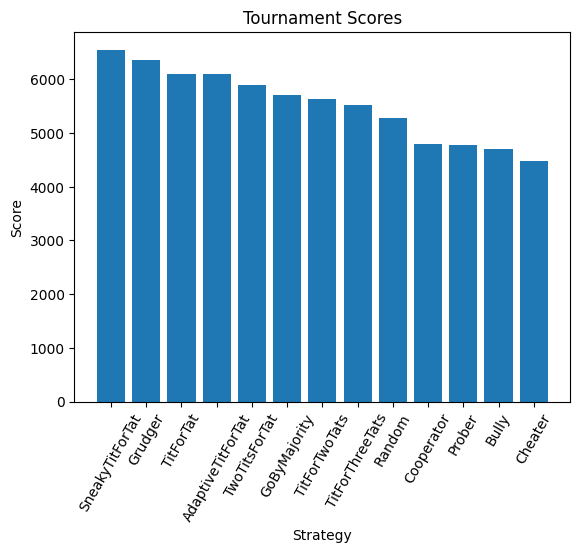

In [ ]:
plt.bar([player.__name__ for player in T.players], T.scores.sum(axis=1))
plt.xticks(rotation=60)
plt.xlabel('Strategy')
plt.ylabel('Score')
plt.title('Tournament Scores')
plt.show()

The results don't quite suggest the supremacy of TitForTat strategy. But maybe that's just because we have chosen quite a bad selection of strategies to compete.

## Let's Evolve

In [ ]:
E = Evolution(Strategies)
E.evolve()

Generation 100 going on
Generation 200 going on
Generation 300 going on
Generation 400 going on
Generation 500 going on
Generation 600 going on
Generation 700 going on
Generation 800 going on
Generation 900 going on
Generation 1000 going on


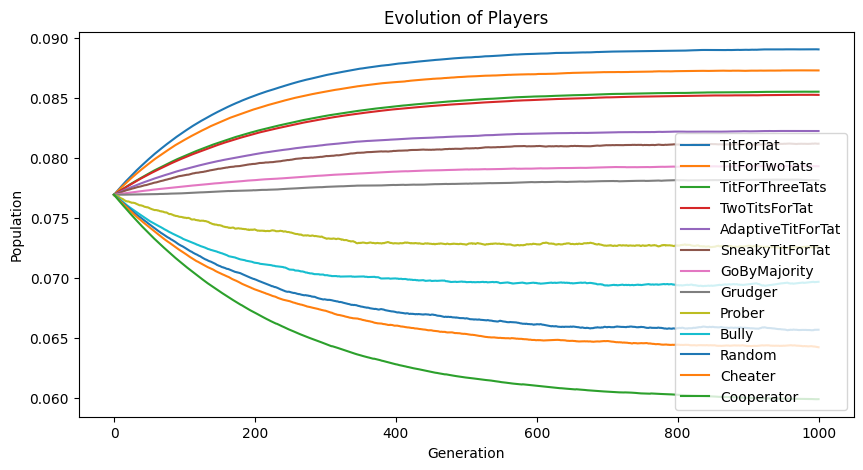

In [ ]:
plt.figure(figsize=(10,5))
for i in range(len(E.players)):
  plt.plot(E.history[:,i], label=E.players[i].__name__)
plt.xlabel('Generation')
plt.ylabel('Population')
plt.title('Evolution of Players')
plt.legend()
plt.show()

So, Tit For Tat wins at last.....!!!!!